<a href="https://colab.research.google.com/github/flavio-mota/sin260-fuzzy/blob/main/SIN260_Sistemas_Inteligentes_L%C3%B3gica_Fuzzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas de Controle Fuzzy

Isabela Neves Drummond
<br>Flávio Belizário da Silva Mota

<hr>

O objetivo deste notebook é apresentar dois exemplos de sistema de controle empregando lógica fuzzy. O primeiro exemplo apresenta um sistema que visa controlar a velocidade de um ventilador, dada a temperatura. O segundo exemplo apresenta o "problema da gorjeta", que é usado comumente para ilustrar o poder dos princípios da lógica fuzzy para gerar comportamento complexo a partir de um conjunto compacto e intuitivo de regras especializadas.

## Velocidade do Ventilador



Esse sistema de controle visa ajustar a velocidade de um ventilador de acordo com a temperatura informada. A temperatura varia numa escala de -10 ºC à 50 ºC. Dada a temperatura de entrada, uma velocidade entre 0 e 120 é acionada.

Esse problema pode ser formulado da seguinte maneira:


> **Antecedentes (Entradas)**:
*   temperatura
  * Universo: Qual é a temperatura do ambiente numa escala de -10 ºC a 50 ºC?
  * Conjunto fuzzy: muito frio, frio, quente, muito quente

> **Consequentes (Saídas)**:
* velocidade
  * Universo: Qual a velocidade do ventilador, numa escala de 0 a 120?
  * Conjunto fuzzy: zero, baixa, média, alta


> **Regras**:
* SE a temperatura estiver muito fria, ENTÃO a velocidade deve ser zero.
* SE a temperatura estiver fria, ENTÃO a velocidade deve ser baixa.
* SE a temperatura estiver quente, ENTÃO a velocidade deve ser média.
* SE a temperatura estiver muito quente, ENTÃO a velocidade deve ser alta.

> **Uso**:
* Se eu disser ao sistema que
  *  a temperatura é de 20 ºC
* ele deverá selecionar uma velocidade de
  * 40

## Criando o sistema de controle fuzzy

Para resolver esse problema, usaremos a biblioteca Scikit-Fuzzy.

A [Scikit-Fuzzy](http://pythonhosted.org/scikit-fuzzy/) é uma biblioteca que implementa uma coleção de algoritmos de lógica fuzzy destinados ao uso no SciPy Stack, escritos na linguagem Python.

Como essa não é uma biblioteca padrão do ambiente colab (e muito provavelmente da sua máquina), é necessário realizar a instalação dos componentes necessários:

In [ ]:
!pip install -U scikit-fuzzy

     |████████████████████████████████| 993 kB 17.1 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=f9b3503c75d704b0403fac56b22560ae4df417e26f345d1941c47c2320f052cb
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


Com a biblioteca instalada, vamos agora definir as variáveis fuzzy do nosso problema:

In [ ]:
## Importação das bibliotecas necessárias
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

## Ajustando o tamanho das figuras
plt.rcParams["figure.figsize"] = (16, 8)

# Variáveis para armazenar os antecedentes e os consequentes
temperatura = ctrl.Antecedent(np.arange(-10, 51, 1), 'temperatura')
velocidade = ctrl.Consequent(np.arange(0, 121, 1), 'velocidade')

Com as variáveis definidas, é possível selecionar qual o método de defuzzificação que será empregado em cada uma delas.

Os métodos permitidos pela biblioteca são:

> * ‘centroid’: centroide da área 
* ‘bisector’: bissetriz da área 
* ‘mom’ : média dos máximos
* ‘som’ : primeiro máximo
* ‘lom’ : maior dos máximos

Por padrão, as variáveis são criadas como 'centroid'. Nesse exemplo vamos ajustar esse método de defuzzificação para 'lom':

In [ ]:
temperatura.defuzzify_method = 'lom'
velocidade.defuzzify_method = 'lom'

Agora vamos definir os níveis de pertinência das variáveis:

In [ ]:
# Definindo os níveis
temperatura['muito_frio'] = fuzz.trapmf(temperatura.universe, [-10,-10,15,20])
temperatura['frio'] = fuzz.trimf(temperatura.universe, [15,20,25])
temperatura['quente'] = fuzz.trimf(temperatura.universe, [20,25,30])
temperatura['muito_quente'] = fuzz.trapmf(temperatura.universe, [25,40,50,50])


velocidade['zero'] = fuzz.trimf(velocidade.universe, [0,0,20])
velocidade['baixa'] = fuzz.trapmf(velocidade.universe, [5,20,40,50])
velocidade['media'] = fuzz.trapmf(velocidade.universe, [40,60,90,120])
velocidade['alta'] = fuzz.trimf(velocidade.universe, [90,120,120])

Podemos visualizar como essas variáveis ficaram:

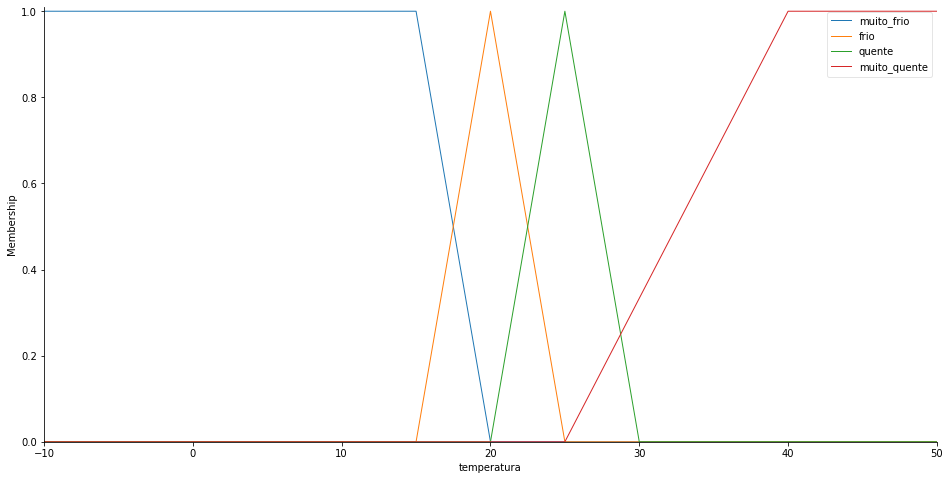

In [ ]:
temperatura.view()

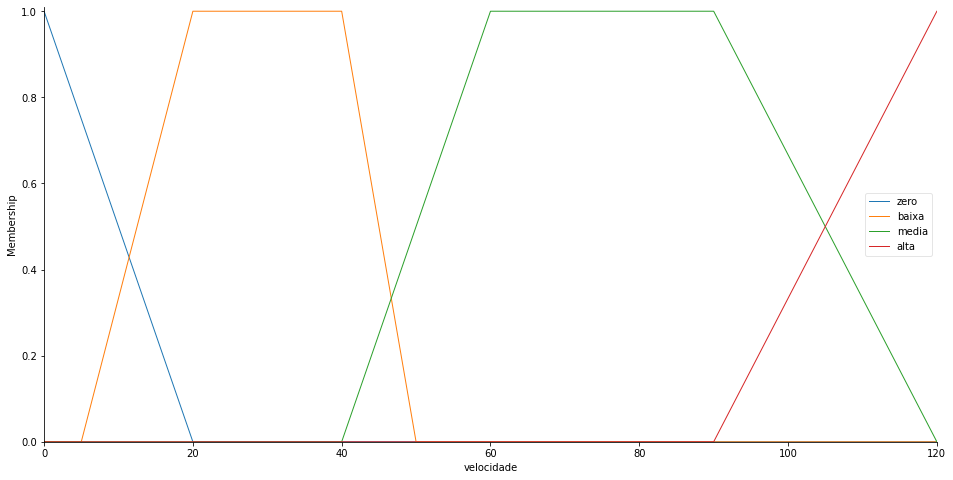

In [ ]:
velocidade.view()

### Regras Fuzzy
Agora, para tornar esses triângulos úteis, definimos a relação fuzzy entre as variáveis ​​de entrada e de saída. Para os propósitos do nosso exemplo, considere quatro regras simples:



1.  SE a temperatura estiver muito fria, ENTÃO a velocidade deve ser zero.
2.  SE a temperatura estiver fria, ENTÃO a velocidade deve ser baixa.
3.  SE a temperatura estiver quente, ENTÃO a velocidade deve ser média.
3.  SE a temperatura estiver muito quente, ENTÃO a velocidade deve ser alta.


Vamos definir essas regras por meio do código:

(<Figure size 1152x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f33a87e3e50>)

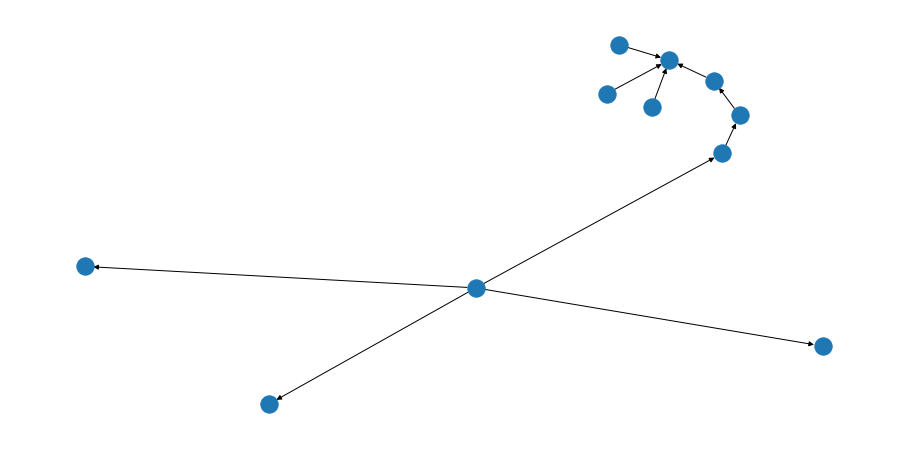

In [ ]:
regra1 = ctrl.Rule(temperatura['muito_frio'], velocidade['zero'])
regra2 = ctrl.Rule(temperatura['frio'], velocidade['baixa'])
regra3 = ctrl.Rule(temperatura['quente'], velocidade['media'])
regra4 = ctrl.Rule(temperatura['muito_quente'], velocidade['alta'])

regra1.view()

### Criando o sistema de controle e simulando

Agora que temos nossas regras definidas, podemos criar o sistema de controle simplesmente usando o trecho de código a seguir:

In [ ]:
controle_ventilador = ctrl.ControlSystem([regra1, regra2, regra3, regra4])

Para simular este sistema de controle, vamos criar um objeto do tipo ControlSystemSimulation. Pense neste objeto representando nosso controlador aplicado a um conjunto específico de circunstâncias:

In [ ]:
ventilador = ctrl.ControlSystemSimulation(controle_ventilador)

Agora podemos simular nosso sistema de controle simplesmente especificando a entrada e chamando o método de computação. Suponha que a temperatura seja de 20 ºC:

In [ ]:
ventilador.input['temperatura'] = 23

ventilador.compute()

Uma vez calculado, podemos exibir o resultado no formato textual, bem como visualizá-lo em um gráfico:

Velocidade:  102.0


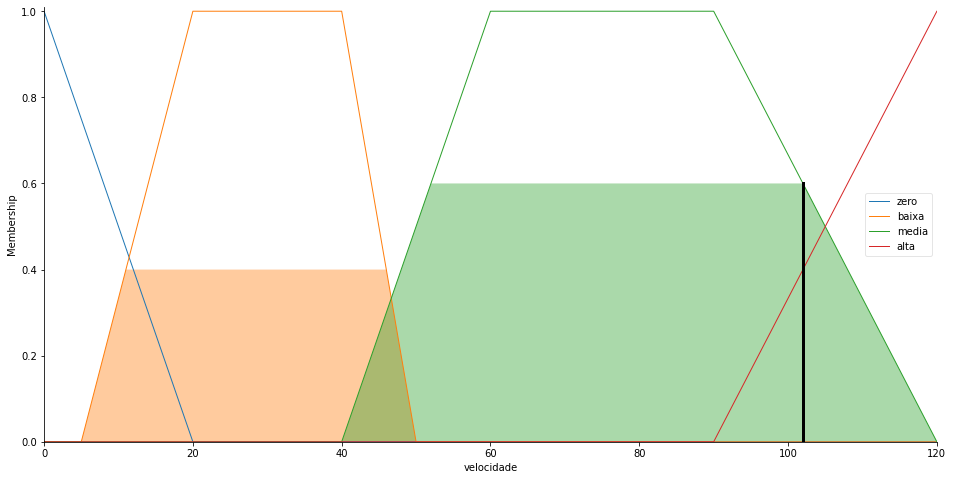

In [ ]:
print('Velocidade: ', ventilador.output['velocidade'])
velocidade.view(sim=ventilador)

## O Problema da Gorjeta

A ideia por trás desse problema é decidir quanto de gorjeta dar ao restaurante. Para isso, deve ser levado em consideração a qualidade do serviço prestado e a qualidade da comida servida, que devem ser avaliados em uma faixa de 0 a 10. Dada a avaliação da qualidade do serviço e da comida, uma gorjeta entre 0 e 25% do valor consumido será deixada.

Esse problema pode ser formulado da seguinte maneira:


> **Antecedentes (Entradas)**:
*   serviço
  * Universo: Quão bom foi o serviço de atendimento dos profissionais do restaurante numa escala de 0 a 10?
  * Conjunto fuzzy: ruim, médio, bom
*   qualidade da comida
  * Universo: Quão saborosa estava a comida, numa escala de 0 a 10?
  * Conjunto fuzzy: ruim, média, boa


> **Consequentes (Saídas)**:
* gorjeta
  * Universo: Quanto de gorjeta devemos dar, numa escala de 0 a 25%?
  * Conjunto fuzzy: baixa, média, alta


> **Regras**:
* SE o serviço foi bom OU a qualidade da comida estava boa, ENTÃO dê uma gorjeta alta.
* SE o serviço foi médio, ENTÃO dê uma gorjeta média.
* SE o serviço foi ruim E a qualidade da comida foi ruim, ENTÃO dê uma gorjeta baixa.

> **Uso**:
* Se eu disser ao sistema que avaliei
  * o serviço com 9.8, e
  * a comida com 6.5,
* ele deverá recomendar uma gorjeta de
  * 20.2%

## Criando o sistema de controle fuzzy

Para resolver o problema da gorjeta, usaremos a biblioteca Scikit-Fuzzy.

Se você não executou o exemplo anterior, as próximas células não irão funcionar. Execute as células 'Criando o sistema de controle fuzzy' do exemplo anterior.

Vamos deifnir as variáveis e os níveis de pertinência. Nesse exemplo, não alteraremos o método padrão da defuzzificação.

In [ ]:
## Importação das bibliotecas necessárias
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

## Ajustando o tamanho das figuras
plt.rcParams["figure.figsize"] = (16, 8)

# Variáveis para armazenar os antecedentes e os consequentes
qualidade = ctrl.Antecedent(np.arange(0, 11, 1), 'qualidade')
servico = ctrl.Antecedent(np.arange(0, 11, 1), 'servico')
gorjeta = ctrl.Consequent(np.arange(0, 26, 1), 'gorjeta')

# Definindo as faixas
qualidade['ruim'] = fuzz.trimf(qualidade.universe, [0, 0, 5])
qualidade['media'] = fuzz.trimf(qualidade.universe, [0, 5, 10])
qualidade['boa'] = fuzz.trimf(qualidade.universe, [5, 10, 10])

servico['ruim'] = fuzz.trimf(servico.universe, [0, 0, 5])
servico['medio'] = fuzz.trimf(servico.universe, [0, 5, 10])
servico['bom'] = fuzz.trimf(servico.universe, [5, 10, 10])

gorjeta['baixa'] = fuzz.trimf(gorjeta.universe, [0, 0, 13])
gorjeta['media'] = fuzz.trimf(gorjeta.universe, [0, 13, 25])
gorjeta['alta'] = fuzz.trimf(gorjeta.universe, [13, 25, 25])

Podemos visualizar como essas variáveis ficaram:

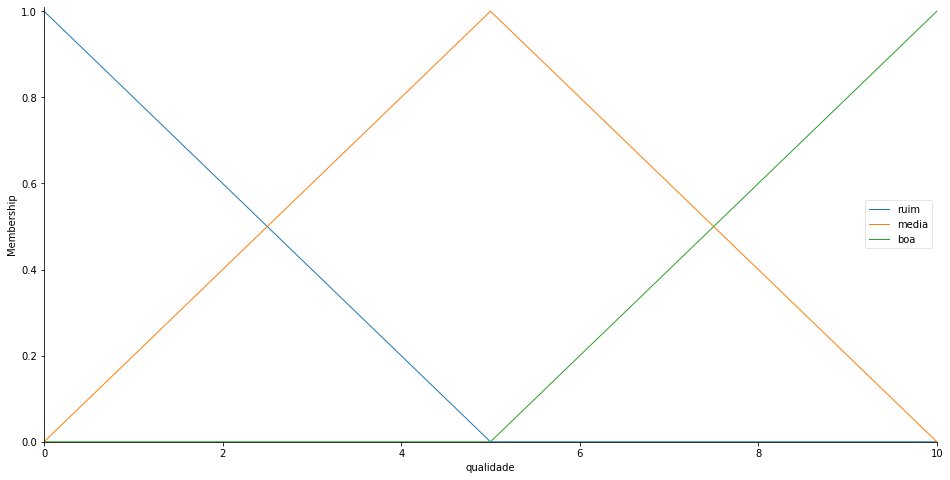

In [ ]:
qualidade.view()

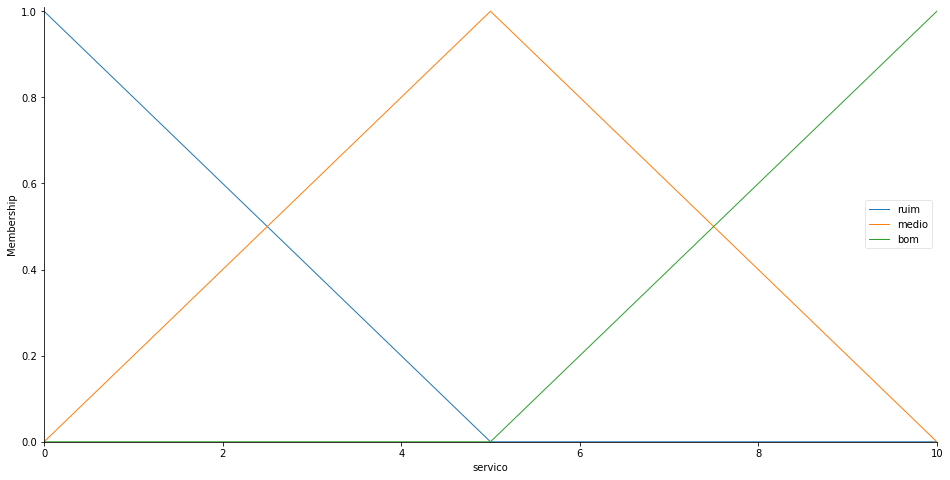

In [ ]:
servico.view()

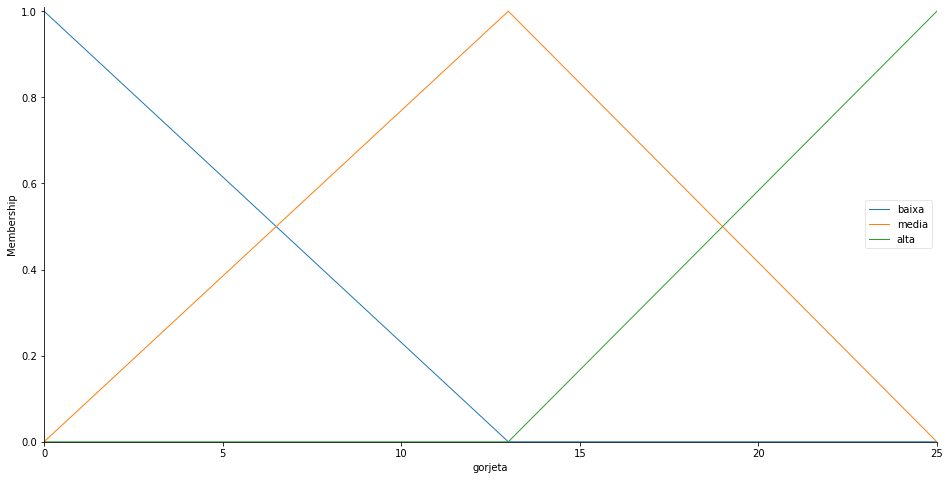

In [ ]:
gorjeta.view()

### Regras Fuzzy
Agora, para tornar esses triângulos úteis, definimos a relação fuzzy entre as variáveis ​​de entrada e de saída. Para os propósitos do nosso exemplo, considere três regras simples:



1.   Se a comida for ruim OU o serviço for ruim, a gorjeta será baixa.
2.   Se o serviço for médio, a gorjeta será média.
3.   Se a comida for boa OU o serviço for bom, a gorjeta será alta.


A maioria das pessoas concordaria com essas regras, mas as regras são imprecisas. Mapear as regras imprecisas em uma ação definida é um desafio. Este é o tipo de tarefa em que a lógica fuzzy se destaca.

Vamos definir essas regras por meio do código:

(<Figure size 1152x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f33a57ebd90>)

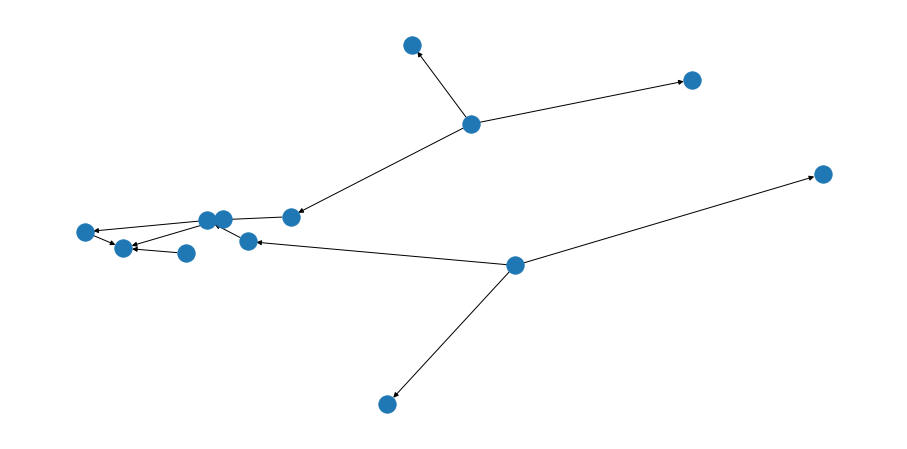

In [ ]:
regra1 = ctrl.Rule(qualidade['ruim'] | servico['ruim'], gorjeta['baixa'])
regra2 = ctrl.Rule(servico['medio'], gorjeta['media'])
regra3 = ctrl.Rule(servico['bom'] | qualidade['boa'], gorjeta['alta'])

regra1.view()

### Criando o sistema de controle e simulando

Agora que temos nossas regras definidas, podemos criar o sistema de controle simplesmente usando o trecho de código a seguir:

In [ ]:
controle_gorjeta = ctrl.ControlSystem([regra1, regra2, regra3])

Para simular este sistema de controle, vamos criar um objeto do tipo ControlSystemSimulation. Pense neste objeto representando nosso controlador aplicado a um conjunto específico de circunstâncias:

In [ ]:
gorjetas = ctrl.ControlSystemSimulation(controle_gorjeta)

Agora podemos simular nosso sistema de controle simplesmente especificando as entradas e chamando o método de computação. Suponha que avaliemos a qualidade com 6,5 de 10 e o serviço com 9,8 de 10:

In [ ]:
gorjetas.input['qualidade'] = 6.5
gorjetas.input['servico'] = 2.0

gorjetas.compute()

Uma vez calculado, podemos exibir o resultado no formato textual, bem como visualizá-lo em um gráfico:

Gorjeta sugerida: 11.01%


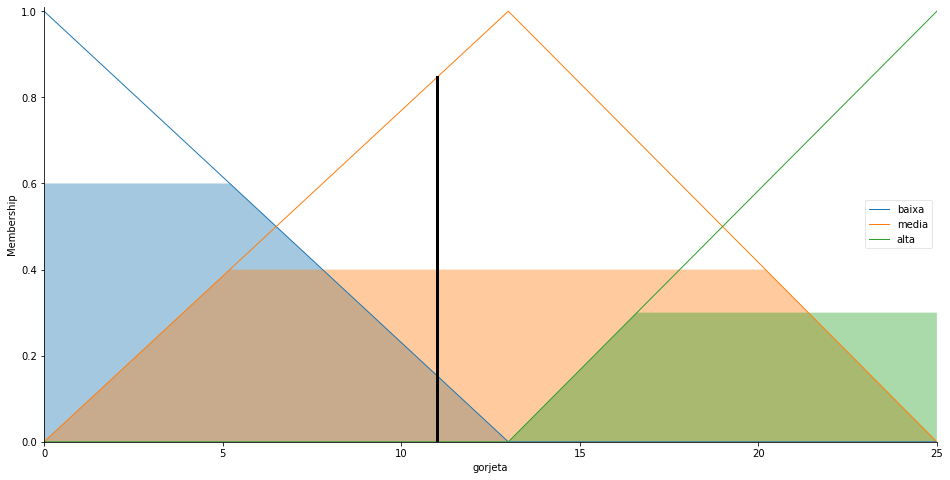

In [ ]:
print('Gorjeta sugerida: %.2f%%' % gorjetas.output['gorjeta'])
gorjeta.view(sim=gorjetas)

<hr>
Fontes:

[The Tipping Problem](https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_tipping_problem_newapi.html)
